In [281]:
%reload_ext autoreload
%autoreload 2

# Analysis 101

To do:
- colour-code points by the distance from the mean pH to contextualise the magnitude of experimental change in pH
- amalgamate any studies with n=1 since need sd for hedges
- deal with temperature-only studies (not all studies have carbonate chemistry)
- plot 3d plot of temperature, ph,


In [492]:
### import
# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# clustering
from sklearn.cluster import KMeans

# custom
import analysis, utils, plotting

In [ ]:
climatology_data_fp = "data/climatology/site_locations_with_MMM_and_pH.csv"

climatology_df = pd.read_csv(climatology_data_fp)
# drop unnecessary columns
climatology_df = climatology_df.drop(columns=['data_ID', 'Unnamed: 0']).set_index('doi')
# TODO: format geometry column(s) into lat and lon
climatology_df.head()

,location,mean_pH_30y_ensemble,models_with_data_n,mean_pH_30y_ensemble_se,MMM_30y_mean,geometry,Unnamed: 9
doi,,,,,,,
10.1111/jpy.13290,"Lizard Island, GBR, Australia",8.086768,10,0.004111,29.046213,c(145.459236111111,-14.6922777777778)
10.1038/s41598-019-40620-8,"Mo'orea, French Polynesia",8.080032,10,0.004959,28.833624,c(-149.839666666667,-17.4779194444444)
10.3354/meps10981,"Key Largo, Florida, US",8.088336,10,0.005121,29.659124,c(-80.49,25.02)
10.3354/meps11591,"Boca Raton, Florida, US",8.085914,10,0.004713,29.430117,c(-80.0721666666667,26.327)
10.3354/meps09309,Palmyra Atoll,8.037819,10,0.005469,28.956142,c(-162.0786656,5.8885026)


In [622]:
climatology_df.index

Index(['10.1111/jpy.13290', '10.1038/s41598-019-40620-8', '10.3354/meps10981',
       '10.3354/meps11591', '10.3354/meps09309', '10.1007/s13131-022-2037-x',
       '10.1016/j.chemgeo.2018.09.004', '10.1007/s00338-019-01775-y',
       '10.3390/jmse10081106', '10.1098/rsos.220760',
       '10.1093/icesjms/fsaa015', '10.1016/j.ecochg.2021.100016',
       '10.1371/journal.pone.0139223', '10.1038/s41598-022-06896-z',
       '10.1007/s00227-022-04071-6', '10.1111/maec.12444',
       '10.3389/fmars.2021.704487', '10.1111/gcb.14998',
       '10.1186/s40168-023-01653-4', '10.1088/1755-1315/253/1/012022',
       '10.1098/rspb.2019.0614', '10.1038/s42003-022-04353-1',
       '10.3389/fmars.2020.581160', '10.1016/j.marenvres.2023.106150',
       '10.1016/j.jembe.2019.151225', '10.1007/s00338-012-0952-6',
       '10.1098/rsos.170683', '10.1098/rspb.2021.0923',
       '10.1111/gcb.13481-LOC-A', '10.1111/gcb.13481-LOC-B',
       '10.1111/gcb.13481-LOC-C', '10.1111/gcb.13481-LOC-D',
       '10.3390/jm

## Multi-variable study

In [285]:
test_doi = climatology_df[climatology_df.index == "10.1111/jpy.13290"]
carb_df = pd.read_pickle("data/temp_carb_df.pkl")
test_df = carb_df.loc[carb_df["doi"] == test_doi.index[0]]
test_df.head()

,authors,calcification,calcification_sd,calcification_se,calcification_units,cleaned_coords,co3,co3_sd,co3_se,coords,...,secondary_check,species_types,t_in,t_in_sd,t_in_se,ta,ta_sd,ta_se,taxa,year
0,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.970803,0.571428,0.25555,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,210.0,NaN,2.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,27.1,NaN,0.06,2292.0,NaN,1.0,Algae,2023-01-01
1,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,2.408759,0.424316,0.18976,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,214.0,NaN,1.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,29.4,NaN,0.08,2291.0,NaN,1.0,Algae,2023-01-01
2,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.664234,0.375356,0.167864,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,117.0,NaN,1.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,27.2,NaN,0.06,2292.0,NaN,1.0,Algae,2023-01-01
3,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.839416,0.277437,0.124074,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,125.0,NaN,1.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Porollithon cf onkodes,29.5,NaN,0.08,2291.0,NaN,1.0,Algae,2023-01-01
4,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,1.467626,0.293757,0.131372,mg cm-2day-1,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,210.0,NaN,2.0,14°41′17.4″ S 145°28′03.6″ E / 14°41′47.0″ S 1...,...,1.0,Lithophyllum cf insipidum,27.1,NaN,0.06,2292.0,NaN,1.0,Algae,2023-01-01


In [286]:
# assign species_types values to unique ints
species_types = test_df["species_types"].unique()
species_types_dict = {species_type: i for i, species_type in enumerate(species_types)}
test_df.loc[:,"species_types"] = test_df["species_types"].map(species_types_dict)

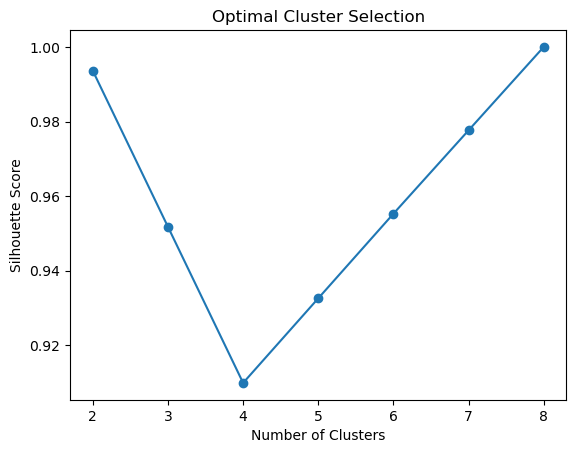

In [287]:
# subset = test_df[test_df["species_types"] == "Porollithon cf onkodes"]
subset = test_df
# Select relevant columns
treatment_data = subset[['t_in', 'phtot', 'irr']].dropna()

# Find optimal number of clusters
optimal_k, score_list = utils.optimal_kmeans(treatment_data)

# Fit KMeans with the best number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
subset.loc[:,'treatment_group'] = kmeans.fit_predict(treatment_data)

# Split dataframe into separate treatments
treatment_groups = {name: group for name, group in subset.groupby('treatment_group')}

# Optional: Plot Silhouette Scores
plt.plot(*zip(*score_list), marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Cluster Selection')
plt.show()

In [288]:
for tg in treatment_groups.values():
    print("TREATMENT GROUP {}".format(tg['treatment_group'].iloc[0]))
    print(tg.loc[:,['t_in', 'phtot', 'irr', 'species_types']])

TREATMENT GROUP 0
   t_in  phtot    irr species_types
1  29.4   7.98  250.0             0
5  29.4   7.98  250.0             1
TREATMENT GROUP 1
    t_in  phtot   irr species_types
9   29.4   7.98  30.0             2
13  29.4   7.98  30.0             3
TREATMENT GROUP 2
   t_in  phtot    irr species_types
2  27.2  7.698  250.0             0
6  27.2  7.698  250.0             1
TREATMENT GROUP 3
    t_in  phtot   irr species_types
8   27.1  8.003  30.0             2
12  27.1  8.003  30.0             3
TREATMENT GROUP 4
   t_in  phtot    irr species_types
0  27.1  8.003  250.0             0
4  27.1  8.003  250.0             1
TREATMENT GROUP 5
    t_in  phtot   irr species_types
10  27.2  7.698  30.0             2
14  27.2  7.698  30.0             3
TREATMENT GROUP 6
   t_in  phtot    irr species_types
3  29.5  7.694  250.0             0
7  29.5  7.694  250.0             1
TREATMENT GROUP 7
    t_in  phtot   irr species_types
11  29.5  7.694  30.0             2
15  29.5  7.694  30.0       

# GPT to scale


In [630]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use your existing function to determine optimal clusters
def optimal_kmeans(data, max_clusters=8):
    best_k = 2  # Minimum sensible number of clusters
    best_score = -1
    scores = []

    for k in range(2, min(len(data), max_clusters + 1)):  # Avoid excessive clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=max_clusters)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        scores.append((k, score))

        if score > best_score:
            best_score = score
            best_k = k

    return best_k, scores


def cluster_treatments(df, vars_to_cluster):
    """Cluster treatments based on independent variables and species types."""
    
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.cluster._kmeans')  # Suppress convergence warnings

    df = df.copy()  # Avoid modifying the original dataframe

    # Ensure 'treatment_group' column exists
    df['treatment_group'] = np.nan

    # Cluster separately for each species type
    for species, group_df in df.groupby('species_types'):
        treatment_data = group_df[vars_to_cluster].dropna(axis=1)  # Only keep non-missing variables

        if treatment_data.shape[0] < 2:  # Skip clustering if there's only one sample
            print(f"Skipping {species}: Not enough samples for clustering")
            continue

        try:
            optimal_k, _ = optimal_kmeans(treatment_data)  # Determine optimal clusters
            kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
            df.loc[group_df.index, 'treatment_group'] = kmeans.fit_predict(treatment_data)
        except ValueError:
            print(f"Error: Could not cluster {species}, df of length {len(group_df)}")
            df.loc[group_df.index, 'treatment_group'] = np.nan

    return df


def determine_control_conditions(df):
    """Identify the rows corresponding to min temperature and/or max pH."""
    grouped = df.groupby('treatment_group')

    control_treatments = {}

    for group, sub_df in grouped:
        group = int(group)  # convert group to integer for consistency
        min_temp = sub_df.loc[sub_df['t_in'].idxmin()]['t_in'] if not any(sub_df['phtot'].isna()) else None # Row with minimum temperature
        max_pH = sub_df.loc[sub_df['phtot'].idxmax()]['phtot'] if not any(sub_df['phtot'].isna()) else None # Row with maximum pH

        control_treatments[group] = {
            'control_t_in': min_temp,
            'control_phtot': max_pH,
        }

    return control_treatments

from itertools import combinations


def compute_hedges_g(df, vars_to_compare=['t_in', 'phtot']):
    """
    Compute Hedges' g effect size for each treatment compared to the control within each species.

    Args:
        df (pd.DataFrame): DataFrame containing treatment groups.
        vars_to_compare (list): List of numeric variables to compute Hedges' g for.

    Returns:
        pd.DataFrame: DataFrame containing effect sizes for each treatment group.
    """
    results = []

    for species, group_df in study_df.groupby('species_types'):
        treatment_groups = group_df['treatment_group'].unique()
        
        # Compare each pair of treatment groups
        for group1, group2 in combinations(treatment_groups, 2):
            df1 = group_df[group_df['treatment_group'] == group1]
            df2 = group_df[group_df['treatment_group'] == group2]
            
            if df1.n.all() == 1 and df2.n.all() == 1:
                # aggregate data (take mean calcification and sd)
                df1['calcification_sd'] = np.std(df1['calcification'])
                df2['calcification_sd'] = np.std(df2['calcification'])
                n1, n2 = len(df1), len(df2)
                
                df1 = utils.aggregate_df(df1)
                df2 = utils.aggregate_df(df2)
                df1['n'] = n1
                df2['n'] = n2

            if len(df1) != len(df2):
                print(f"Skipping comparison between {group1} and {group2} treatments: Different sample sizes")
                continue
            
            if isinstance(df1, pd.DataFrame):   # if there are multiple samples
                for sample in range(len(df1)):
                    df1_sample = df1.iloc[sample]
                    df2_sample = df2.iloc[sample]
                    
                    for var in vars_to_compare:

                        other_var = 't_in' if var == 'phtot' else 'phtot'  # The variable that must remain constant
                        
                        # Check if the other variable is approximately the same in both groups
                        if np.isclose(df1_sample[other_var], df2_sample[other_var], atol=0.05):  # Adjust tolerance as needed
                            if var == 'phtot':
                                # mu1 is greater than mu2, switch groups such that control = mu1
                                if df1_sample[var] < df2_sample[var]:
                                    group1, group2 = group2, group1
                                    df1_sample, df2_sample = df2_sample, df1_sample
                                delta_var = df2_sample[var] - df1_sample[var]
                            elif var == 't_in':
                                # mu1 is less than mu2, switch groups such that control = mu1
                                if df1_sample[var] > df2_sample[var]:
                                    group1, group2 = group2, group1
                                    df1_sample, df2_sample = df2_sample, df1_sample
                                delta_var = df1_sample[var] - df2_sample[var]
                                    
                            mu1, std1, n1 = df1_sample['calcification'], df1_sample['calcification_sd'], df1_sample['n']
                            mu2, std2, n2 = df2_sample['calcification'], df2_sample['calcification_sd'], df2_sample['n']

                            g = analysis.calc_hedges_g(mu2, mu1, std2, std1, n2, n1)    # TODO: check signage
                            results.append({
                                'doi': study_df.doi.iloc[0],
                                'species_types': species,
                                'group1': group1,
                                'group2': group2,
                                'variable': var,
                                'delta_var': delta_var,
                                'hedges_g': g[0],
                                'hg_ci_l': g[1][0],
                                'hg_ci_u': g[1][1],
                                })
            else:
                df1_sample = df1
                df2_sample = df2
                for var in vars_to_compare:
                    
                    other_var = 't_in' if var == 'phtot' else 'phtot'  # The variable that must remain constant
                    
                    # Check if the other variable is approximately the same in both groups
                    if np.isclose(df1_sample[other_var], df2_sample[other_var], atol=0.05):  # Adjust tolerance as needed
                        if var == 'phtot':
                            # mu1 is greater than mu2, switch groups such that control = mu1
                            if df1_sample[var] < df2_sample[var]:
                                group1, group2 = group2, group1
                                df1_sample, df2_sample = df2_sample, df1_sample
                            delta_var = df2_sample[var] - df1_sample[var]
                        elif var == 't_in':
                            # mu1 is less than mu2, switch groups such that control = mu1
                            if df1_sample[var] > df2_sample[var]:
                                group1, group2 = group2, group1
                                df1_sample, df2_sample = df2_sample, df1_sample
                            delta_var = df2_sample[var] - df1_sample[var]
                                
                        mu1, std1, n1 = df1_sample['calcification'], df1_sample['calcification_sd'], df1_sample['n']
                        mu2, std2, n2 = df2_sample['calcification'], df2_sample['calcification_sd'], df2_sample['n']

                        g = analysis.calc_hedges_g(mu2, mu1, std2, std1, n2, n1)    # TODO: check signage
                        results.append({
                            'doi': study_df.doi.iloc[0],
                            'location': study_df.location.iloc[0],
                            'species_types': species,
                            'group1': group1,
                            'group2': group2,
                            'variable': var,
                            'delta_var': delta_var,
                            'hedges_g': g[0],
                            'hg_ci_l': g[1][0],
                            'hg_ci_u': g[1][1],
                            'control_val': df1_sample[var],
                            'treatment_val': df2_sample[var],
                        })
    return results


all_results = []
failures = []
for study_name, study_df in carb_df.groupby('doi'):
    print(f"Processing study: {study_name}")
    
    if len(study_df) < 2:
        print(f"Skipping study {study_name} due to insufficient data for hedges g calculation.")
        continue
    
    # 1. assign treatment groups to each row
    study_df = cluster_treatments(study_df, independent_vars)
    if any(study_df['treatment_group'].isna()):
        failures.append(study_name)
        continue
    # 2. identify control conditions (min_temp, max_pH)
    control_conditions = determine_control_conditions(study_df)

    # 3. compute Hedges' g for each treatment group
    hedges_results = compute_hedges_g(study_df)
    all_results.extend(hedges_results)

print(f"\nFailed to cluster {len(failures)} studies: {failures}")

results_df = pd.DataFrame(all_results).set_index('doi')
results_df.head()

Processing study: 10.1007/s00227-016-2986-8
Processing study: 10.1007/s00227-022-04071-6
Processing study: 10.1007/s00338-012-0952-6
Processing study: 10.1007/s00338-019-01775-y
Processing study: 10.1007/s00338-020-01995-7
Error: Could not cluster Monstastraea cavernosa, df of length 6
Processing study: 10.1007/s13131-022-2037-x
Processing study: 10.1016/j.chemgeo.2018.09.004
Processing study: 10.1016/j.ecochg.2021.100016
Processing study: 10.1016/j.jembe.2016.10.002
Processing study: 10.1016/j.jembe.2019.151225
Processing study: 10.1016/j.marenvres.2023.106150
Processing study: 10.1029/2020JG005726
Error: Could not cluster Operculina ammonoides, df of length 96
Processing study: 10.1038/s41598-019-40620-8
Processing study: 10.1038/s41598-022-06896-z
Processing study: 10.1038/s42003-022-04353-1
Processing study: 10.1088/1755-1315/253/1/012022
Processing study: 10.1093/icesjms/fsaa015
Processing study: 10.1098/rsos.170683
Processing study: 10.1098/rsos.220760
Processing study: 10.1098/r

,location,species_types,group1,group2,variable,delta_var,hedges_g,hg_ci_l,hg_ci_u,control_val,treatment_val
doi,,,,,,,,,,,
10.1007/s00227-016-2986-8,"Mo'orea, French Polynesia",Acropora pulchra,2.0,1.0,phtot,-0.330000,-2.238796,-3.868438,-0.609153,8.010000,7.680000
10.1007/s00227-016-2986-8,"Mo'orea, French Polynesia",Acropora pulchra,3.0,2.0,t_in,2.750000,-0.430611,-1.711220,0.849997,27.350000,30.100000
10.1007/s00227-016-2986-8,"Mo'orea, French Polynesia",Acropora pulchra,0.0,1.0,t_in,2.800000,-1.056397,-2.367992,0.255199,27.250000,30.050000
10.1007/s13131-022-2037-x,South China Sea,Halimeda opuntia,1.0,2.0,phtot,-0.215376,0.904121,-0.379184,2.187426,8.005938,7.790562
10.1007/s13131-022-2037-x,South China Sea,Halimeda opuntia,0.0,2.0,t_in,0.100000,-1.612635,-3.194758,-0.030512,27.000000,27.100000


In [655]:
set(results_df.index) - set(climatology_df.index)

{'10.1007/s00227-016-2986-8',
 '10.1016/j.jembe.2016.10.002',
 '10.1111/gcb.13481'}

In [658]:
results_df.merge(climatology_df, left_index=True, right_index=True)

,location_x,species_types,group1,group2,variable,delta_var,hedges_g,hg_ci_l,hg_ci_u,control_val,treatment_val,location_y,mean_pH_30y_ensemble,models_with_data_n,mean_pH_30y_ensemble_se,MMM_30y_mean,geometry,Unnamed: 9
doi,,,,,,,,,,,,,,,,,,
10.1007/s13131-022-2037-x,South China Sea,Halimeda opuntia,1.0,2.0,phtot,-0.215376,0.904121,-0.379184,2.187426,8.005938,7.790562,South China Sea,8.077275,10,0.003507,29.295134,c(111.3,17.05)
10.1007/s13131-022-2037-x,South China Sea,Halimeda opuntia,0.0,2.0,t_in,0.100000,-1.612635,-3.194758,-0.030512,27.000000,27.100000,South China Sea,8.077275,10,0.003507,29.295134,c(111.3,17.05)
10.1016/j.ecochg.2021.100016,"Almirante Bay, Panama",Lithophyllum sp.,1.0,2.0,t_in,0.200000,0.507994,0.043523,0.972466,29.000000,29.200000,"Almirante Bay, Panama",8.072893,10,0.004361,29.059954,c(-82.2311642,9.2993407)
10.1016/j.ecochg.2021.100016,"Almirante Bay, Panama",Lithophyllum sp.,3.0,2.0,t_in,0.300000,0.542597,0.073842,1.011351,28.900000,29.200000,"Almirante Bay, Panama",8.072893,10,0.004361,29.059954,c(-82.2311642,9.2993407)
10.1016/j.ecochg.2021.100016,"Almirante Bay, Panama",Lithophyllum sp.,0.0,2.0,t_in,0.400000,1.338076,0.831506,1.844646,28.800000,29.200000,"Almirante Bay, Panama",8.072893,10,0.004361,29.059954,c(-82.2311642,9.2993407)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.3354/meps09309,Palmyra Atoll,Halimeda opuntia,0.0,1.0,phtot,NaN,NaN,NaN,NaN,7.883266,NaN,Palmyra Atoll,8.037819,10,0.005469,28.956142,c(-162.0786656,5.8885026)
10.3354/meps09309,Palmyra Atoll,Halimeda taenicola,0.0,1.0,phtot,NaN,NaN,NaN,NaN,NaN,NaN,Palmyra Atoll,8.037819,10,0.005469,28.956142,c(-162.0786656,5.8885026)
10.3354/meps11591,"Boca Raton, Florida, US",Halimeda discoidea,0.0,1.0,t_in,0.000000,0.048801,-1.156570,1.254172,26.200000,26.200000,"Boca Raton, Florida, US",8.085914,10,0.004713,29.430117,c(-80.0721666666667,26.327)


In [666]:
# Match by DOI the Hedges' g results with the climatology data
# matched_df = results_df.join(climatology_df, how="left", rsuffix="_clim")
matched_df = results_df.merge(climatology_df, left_index=True, right_index=True)

# Define mapping of climatology variables to treatment variables
clim_var_map = {'t_in': 'MMM_30y_mean', 'phtot': 'mean_pH_30y_ensemble'}

# Calculate difference between treatment and historic conditions dynamically
matched_df['clim_delta'] = matched_df.apply(
    lambda row: row['treatment_val'] - row[clim_var_map[row['variable']]]
    if row['variable'] in clim_var_map else np.nan,
    axis=1
)

In [676]:
len(climatology_df.index) - len(utils.read_yaml("data/locations.yaml").keys())


0

In [667]:
print(len(matched_df))
print(matched_df.clim_delta.isna().sum())

76
10


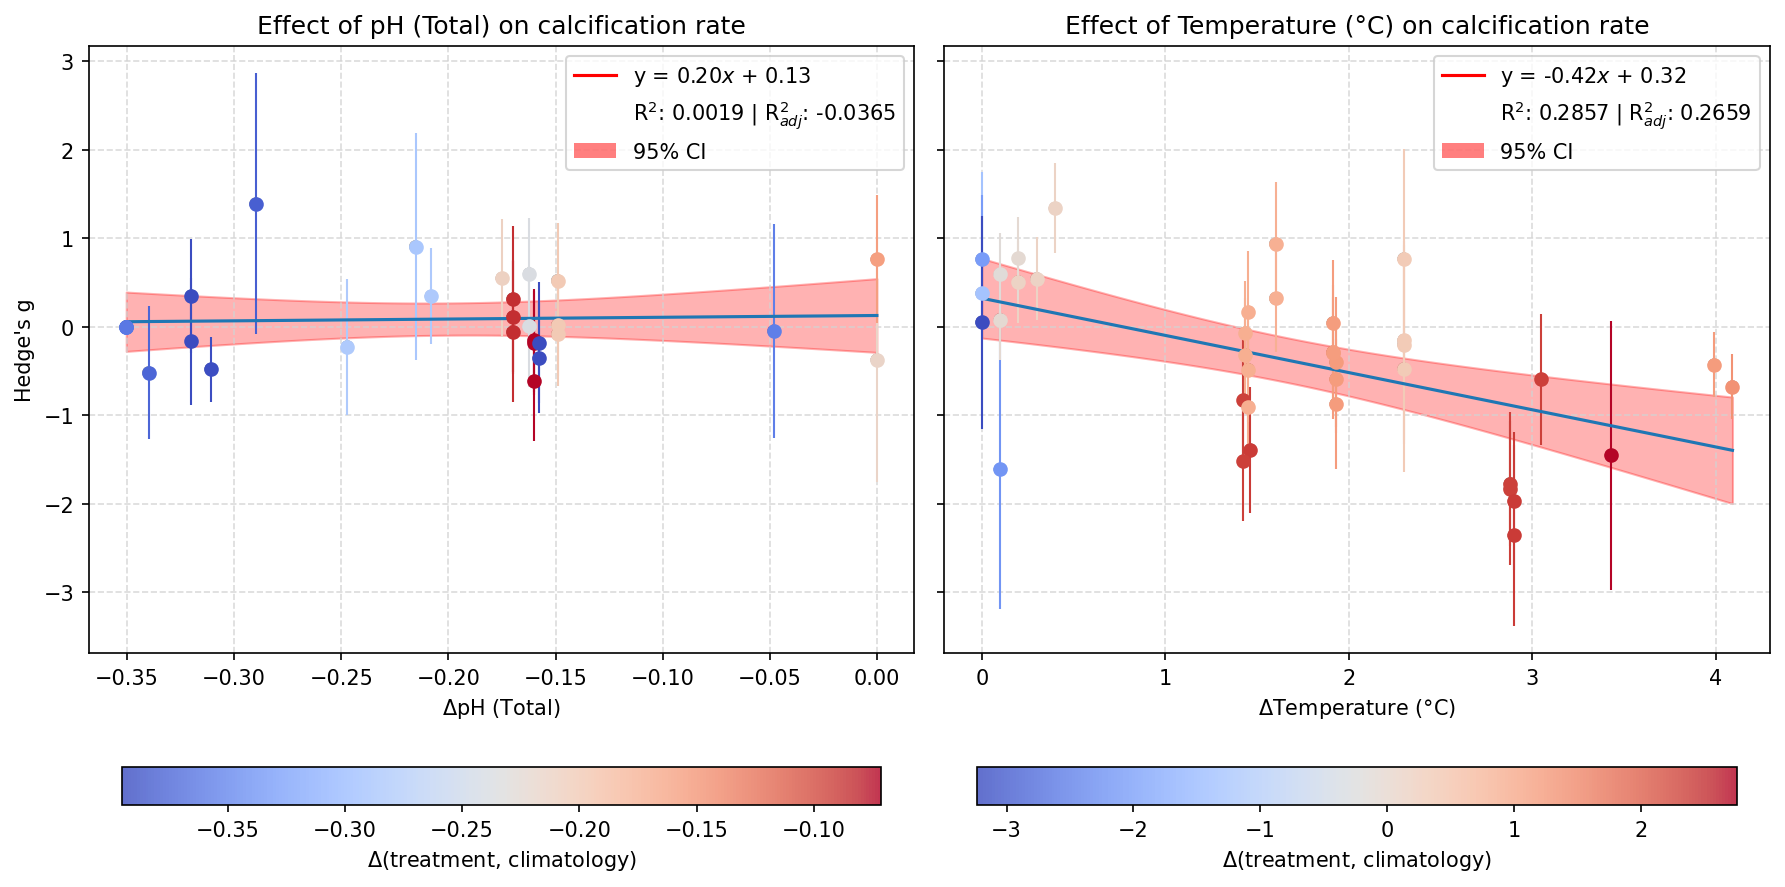

In [662]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    subset = matched_df[matched_df['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])  # remove any rows containing nans
    
    cmap = cm.coolwarm
    norm = mcolors.Normalize(vmin=subset['clim_delta'].min(), vmax=subset['clim_delta'].max())
    colors = [cmap(norm(val)) for val in subset['clim_delta']]

    # Plot error bars **matching scatter point colors**
    for i, (x, y, yerr, color) in enumerate(zip(subset['delta_var'], subset['hedges_g'], 
                                                (subset['hedges_g'] - subset['hg_ci_l']).values, 
                                                colors)):
        ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='o', color=color, alpha=1, lw=1)

    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c=subset['clim_delta'], cmap=cmap, norm=norm, 
                         alpha=0.8, lw=0.1, edgecolor='black')

    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # add colourbar for clim_delta
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, orientation="horizontal")
    cbar.set_label(f"$\\Delta$(treatment, climatology)")
    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    # setting up legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none', alpha=0.5)
    ax.plot([],[],alpha=0,label = f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

In [309]:
sel_cols = ['species_types', 'treatment_group', 'phtot', 't_in', 'irr', 'calcification', 'calcification_sd', 'n']
study_df[sel_cols]

,species_types,treatment_group,phtot,t_in,irr,calcification,calcification_sd,n
0,Porollithon cf onkodes,1.0,8.003,27.1,250.0,1.970803,0.571428,5.0
1,Porollithon cf onkodes,0.0,7.980,29.4,250.0,2.408759,0.424316,5.0
2,Porollithon cf onkodes,1.0,7.698,27.2,250.0,1.664234,0.375356,5.0
3,Porollithon cf onkodes,0.0,7.694,29.5,250.0,1.839416,0.277437,5.0
4,Lithophyllum cf insipidum,1.0,8.003,27.1,250.0,1.467626,0.293757,5.0
5,Lithophyllum cf insipidum,0.0,7.980,29.4,250.0,0.949640,0.767206,5.0
6,Lithophyllum cf insipidum,1.0,7.698,27.2,250.0,0.043165,0.310077,5.0
7,Lithophyllum cf insipidum,0.0,7.694,29.5,250.0,0.258993,0.180259,5.0
8,Lithothamnion proliferum,1.0,8.003,27.1,30.0,1.778571,0.048960,5.0
9,Lithothamnion proliferum,0.0,7.980,29.4,30.0,1.457143,0.130559,5.0


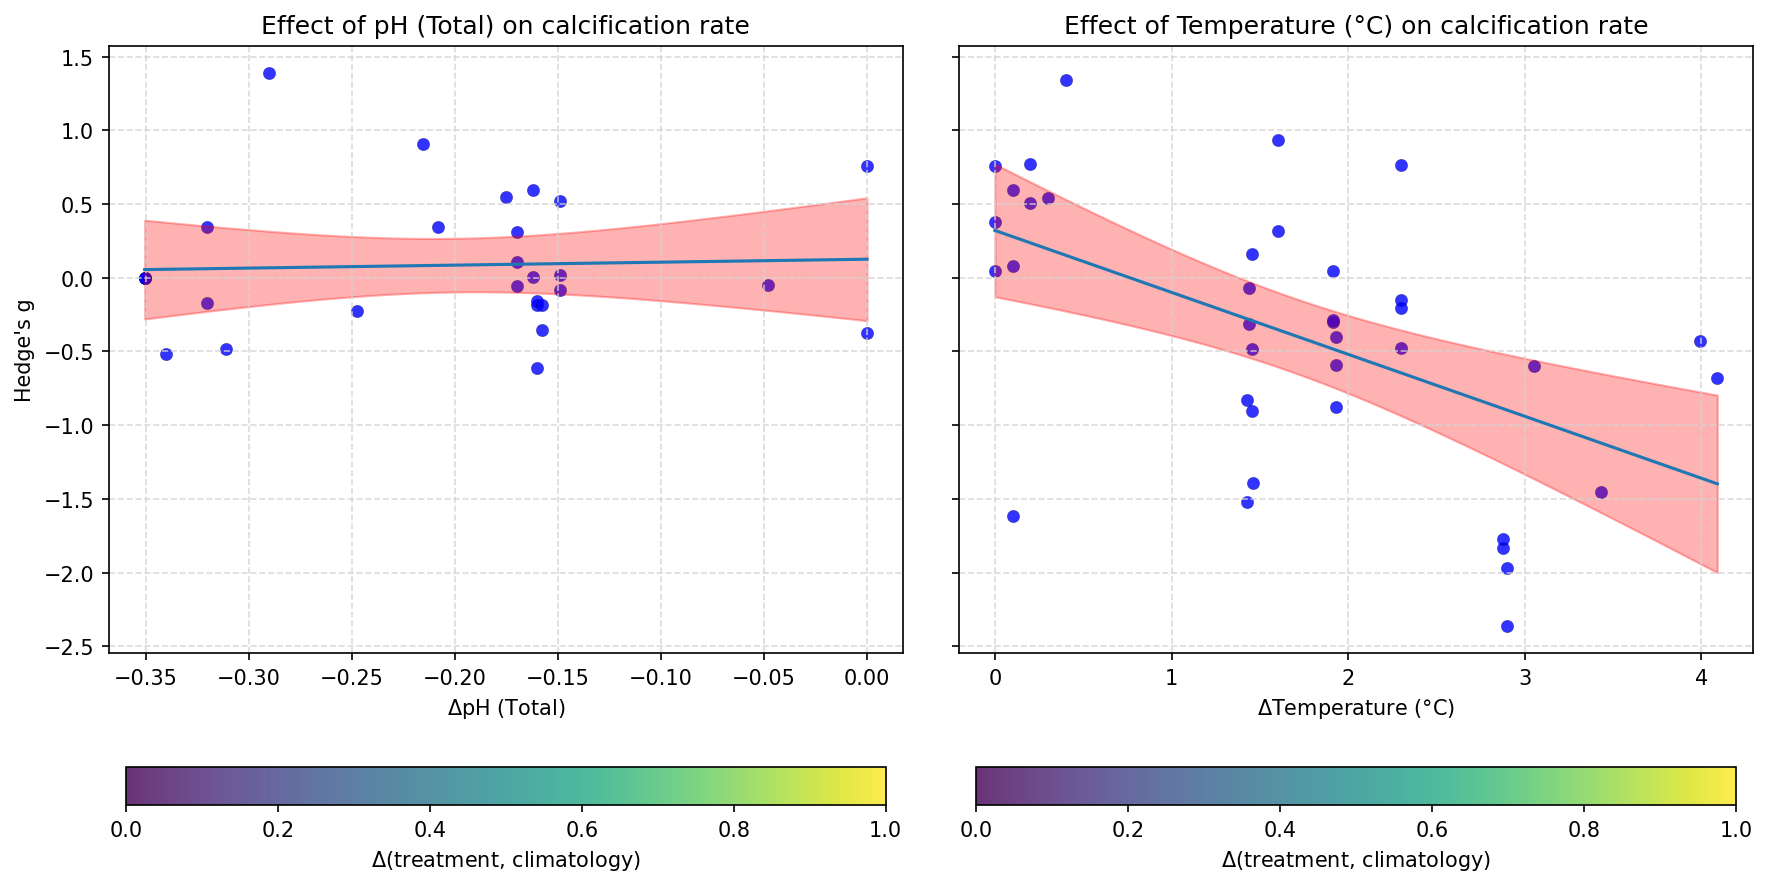

In [585]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    subset = matched_df[matched_df['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])        # remove any rows containing nans
    


    # Scatter plot with color mapping
    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c='blue',
                         alpha=0.8, lw=0.1, edgecolor='black')

    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # add colourbar for clim_delta
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, orientation="horizontal")
    cbar.set_label(f"$\\Delta$(treatment, climatology)")
    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    # setting up legend

    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()